***Méthodes numériques, PHYS-F302 (Module 5).***
*********************************
Stokes-flow in a square cavity.
==
### But #
Etudier l'écoulement d'un fluide  dominé par les forces de viscosité dans une cavité rectangulaire.
Pour ce faire, on va exprimer le problème en terme de:
- la fonction de flot $\psi$ qui représente les lignes de courant du fluide 
- et du vecteur de vorticité $\omega$ qui caractérise l'écoulement "tourbillonaire" du fluide, c'est-à-dire l'écoulement suivant un mouvement de rotation autour d'un axe.

### Principe #
L'écoulement de n'importe quel fluide incompressible est décrit par l'équation de Navier-Stokes:
\begin{equation}
\frac{\partial \vec{v}}{\partial t} + (\vec{v} \cdot \vec{\nabla}) \vec{v} = -\frac{1}{\rho}\vec{\nabla} P + \nu\nabla^2 \vec{v}
\end{equation}
Où $\vec{v}$ est la vitesse du fluide, $P$ est la pression, $\rho$ est la densité et $\nu$ est la viscosité cinématique: 
$\nu=\frac{\mu}{\rho}$ avec $\mu$ la viscosité dynamique. On peut réécrire l'équation en terme de $u$ et $p$ la vitesse et la pression sans dimension:
\begin{equation}
Re*\left(\frac{\partial \vec{u}}{\partial t} + (\vec{u} \cdot \vec{\nabla}) \vec{u} \right) = -\vec{\nabla} p + \nabla^2 \vec{u}
\end{equation}
où $Re=\frac{\rho V*L}{\mu}$ est le nombre de Reynold (V est une vitesse caractéristique et L est une longueur caractéristique, ce qui permet que $u$ et $p$ soient sans dimension).
Par définition, l'écoulement de Stokes (fluide où les forces de viscosité dominent) est défini par le domaine $Re << 1$.
Pour résoudre l'équation, on se place dans l'approximation $Re≃0$.

On définit la vorticité par: $$\vec{\omega}=\vec{\nabla} \times \vec{u}$$
En remaniant l'équation de Navier-Stokes, elle devient: $$\nabla^2\vec{\omega}=0$$
### Equation à deux dimensions #
On définit la fonction de flot $\psi$ par:
\begin{align}
\frac{\partial \psi}{\partial x}&=-u_{y}\\
\frac{\partial \psi}{\partial y}&=u_{x}
\end{align}
En deux dimension, la vitesse est entièrement comprise dans le plan XY et donc 
\begin{equation}
\vec{\omega}=\omega \vec{1}_{z} \Rightarrow \omega=\frac{\partial u_{y}}{\partial x}-\frac{\partial u_{x}}{\partial y}
=-\frac{\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2}
\end{equation}
\begin{equation}
\Leftrightarrow
\nabla^2 \psi = -\omega
\end{equation}
### Problème à résoudre
Nous allons donc résoudre les équations pour le flot et la vorticité dans un carré en deux dimensions. Le fluide est initialement au repos à l'intérieur du carré mais le bord supérieur du carré avance à une vitesse $u_{x}=1$, ce qui va entraîner le fluide et créer un flot non nul.
On doit donc finalement résoudre le système couplé d'équations suivant:
\begin{equation}
\nabla^2 \omega = 0
\end{equation}

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation} 
Pour ce faire, nous allons utiliser les différentes méthodes itératives apprises dans ce module (itération de Jacobi, de Gauss-Seidel, SOR, Steepest Descent et Gradients conjugués).
Ceci nous permettra d'une part d'interprèter physiquement le résultat et de comprendre comment s'écoule le fluide dans la cavité et d'autre part de tester ces différentes méthodes et de comparer leur convergence.



## 1. Itération de Jacobi
On commence par cette méthode parce que c'est la plus simple à comprendre. On verra ensuite qu'elle est peu efficace et on la comparera aux autres méthodes.

In [2]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [4]:
import numba
from numba import jit

On définit ici deux fonctions qui vont nous permettre de visualiser notre solution, la première par un plot 3D et la seconde par une carte couleur en 2D:

In [5]:
def plot_3D(x, y, p,title):

    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(title)
    ax.view_init(30,45)

In [6]:
def colormap(x,y,psi,title):

    fig=pyplot.figure(figsize=(9,6))
    X,Y = numpy.meshgrid(x,y)
    pyplot.ylim(0,nx-1)
    pyplot.xlim(0,ny-1)
    pyplot.xlabel('x (dx)')
    pyplot.ylabel('y (dy)')
    pyplot.imshow(psi, cmap = cm.viridis)  
    pyplot.title(title)
    pyplot.colorbar();

#### Paramètres du problème:
Nous les définissons une fois pour toutes ici et sauf redéfinition, il seront valables pour toutes les méthodes.

In [7]:
nx = 41
ny = 41

l = 1.#length of the square in the x-direction 
h = 1.#length of the square in the y-direction

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6
l1_target2=1e-8

Notre condition d'arrêt sera donnée en fonction de la norme L1 de la différence entre deux itérations successives:

In [8]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

## Conditions au bord:
Ces conditions sont valables pour toutes les méthodes.
- $\psi$ est nul sur les quatres bords du carré
- $\nabla^2 \psi = -\omega$

#### TOP: $\psi=0, \frac{\partial \psi}{\partial y}=1$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial y^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta y^{2}}\left(8\psi_{i,j-1}-\psi_{i,j-2}\right)-\frac{3}{\Delta y}$

#### RIGHT: $\psi=0, \frac{\partial \psi}{\partial x}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial x^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta x^{2}}\left(8\psi_{i-1,j}-\psi_{i-2,j}\right)$

#### LEFT: $\psi=0, \frac{\partial \psi}{\partial x}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial x^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta x^{2}}\left(8\psi_{i+1,j}-\psi_{i+2,j}\right)$

#### BOTTOM: $\psi=0, \frac{\partial \psi}{\partial y}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial y^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta y^{2}}\left(8\psi_{i,j+1}-\psi_{i,j+2}\right)$





#### Discrétisation des équations par la méthode de Jacobi:
\begin{equation}
\begin{aligned}
\nabla^2 \omega = 0 &\Rightarrow \omega^{k+1}_{i,j} = \frac{1}{4} \left(\omega^{k}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k}_{i-1,j} + \omega^k_{i+1,j} \right)\\
\nabla^2 \psi = -\omega &\Rightarrow \psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k})\Delta x^2+\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{aligned}
\end{equation}

In [9]:
def stokesjacobi(w,psi):

    l1norm_w = 1
    l1norm_psi=1
    wn= numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0

  
    while (l1norm_w>l1_target or l1norm_psi>l1_target) :
        
        wn = w.copy()
        psin=psi.copy()
        w[1:-1,1:-1] = .25 * (wn[1:-1,2:] + wn[1:-1, :-2] \
                              + wn[2:, 1:-1] + wn[:-2, 1:-1])
        
        
        psi[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((psin[1:-1,2:]+psin[1:-1,:-2])*dy**2 +\
                        (psin[2:,1:-1] + psin[:-2,1:-1])*dx**2 +\
                         wn[1:-1,1:-1]*dx**2*dy**2)

            
        #BC on the edge of the square:
        w[-1,:]=(-1/(dy)**2)*(4*psi[-2,:]-psi[-3,:]/2)-3.0/dy 
        w[0,:]=(-1/(dy)**2)*(4*psi[1,:]-psi[2,:]/2) 
        w[:,-1]=(-1/(dx)**2)*(4*psi[:,-2]-psi[:,-3]/2)
        w[:,0]=(-1/(dx)**2)*(4*psi[:,1]-psi[:,2]/2)
        
        l1norm_w=L1norm(w,wn)
        l1norm_psi=L1norm(psi,psin)
        
    
        iterations += 1 
        
    
    
    print(iterations,l1norm_w,l1norm_psi)
    
    return psi,w

In [10]:
%%timeit

w_jac=numpy.zeros((ny,nx))
psi_jac=numpy.zeros((ny,nx))
w_jac[-1,:]=-3/dy

psi_jac,w_jac= stokesjacobi(w_jac.copy(),psi_jac.copy())

4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
1 loop, best of 3: 276 ms per loop


4059 9.99748259765e-07 2.2423296163e-08


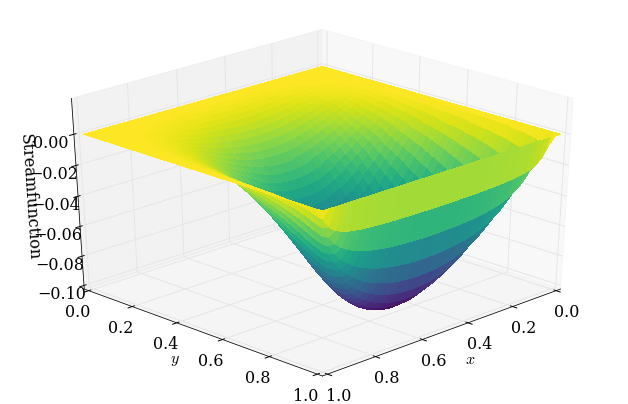

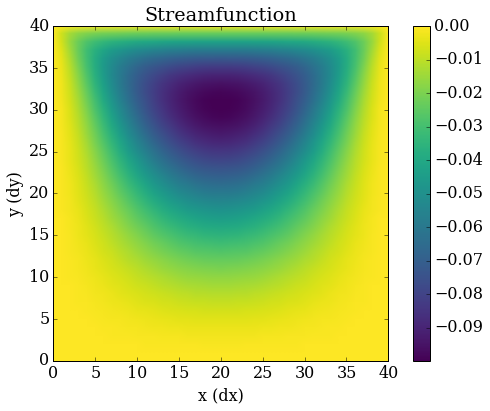

In [11]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w_jac=numpy.zeros((nx,ny))
psi_jac=numpy.zeros((nx,ny))
w_jac[-1,:]=-3/dy

psi_jac, w_jac= stokesjacobi(w_jac.copy(),psi_jac.copy())
plot_3D(x,y,psi_jac,'Streamfunction')
colormap(x,y,psi_jac,'Streamfunction')

#### Jacobi avec Numba
Avant toute chose, nous allons utiliser "jit" et numba pour améliorer notre code. Ils vont en fait compiler notre code et l'optimiser.
Cela ne va pas changer le nombre d'itérations nécessaires qui est propre à la méthode mais cela devrait accélérer l'éxécution.
Nous allons devoir utiliser des boucles pour permettre l'utilisation de Numba.

D'autre part, nous souhaitons stocker les valeurs de la norme de $\psi$ au cours des itérations successives dans le but d'examiner la convergence de nos différentes méthodes.
Nous faisons donc en sorte que notre fonction crée désormais une liste contenant ces valeurs.
Elle doit contenir au moins autant d'éléments que d'itérations (car on a une norme de $\psi$ calculée par itération). Nous avons vu plus haut que le nombre d'itération pour Jacobi était de 4059. Ce nombre d'itérations devant diminuer pour les méthodes suivantes, nous partirons toujours d'une liste de 4060 éléments par la suite.

In [12]:
@jit(nopython=True)
def stokesjacobi_bis(w,psi):

    l1norm_w = 1
    l1norm_psi=1
    wn= numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    normlist=numpy.zeros
    iterations=0
    normpsi_list=numpy.zeros(4060)
  
    while (l1norm_w>l1_target or l1norm_psi>l1_target) :
        
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = .25 * (wn[j,i+1] + wn[j,i-1] \
                              + wn[j+1,i] + wn[j-1,i])
        
       
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psin[j,i+1]+psin[j,i-1])*dy**2 +\
                        (psin[j+1,i] + psin[j-1,i])*dx**2 +\
                         wn[j,i]*dx**2*dy**2)
            
        ##B.C on the top of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)

        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
       
        normpsi_list[iterations]= l1norm_psi
    
        iterations += 1 


        
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi,w,normpsi_list,iterations

In [13]:
%%timeit

w_jac2=numpy.zeros((ny,nx))
psi_jac2=numpy.zeros((ny,nx))
w_jac2[-1,:]=-3/dy

psi_jac2,w_jac2,normpsilist_jac,iterations_jac= stokesjacobi_bis(w_jac2.copy(),psi_jac2.copy())

4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
The slowest run took 18.75 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 32.8 ms per loop


Numba a divisé par dix le temps nécessaire à l'éxécution de notre code, ce qui est une bonne nouvelle. Comme prévu, le nombre d'itération est toujours le même.

4059 9.997482597647045e-07 2.24232961630431e-08


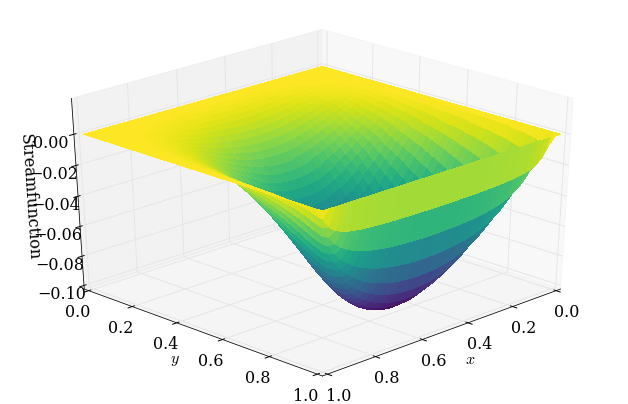

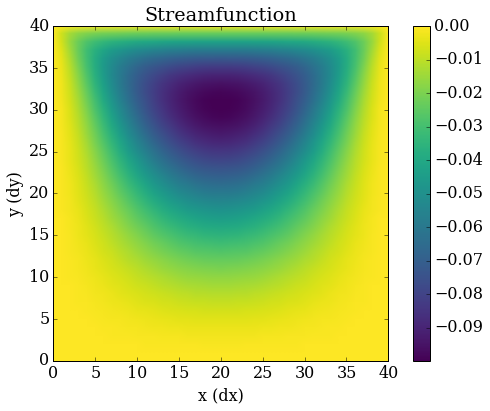

In [14]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w_jac2=numpy.zeros((nx,ny))
psi_jac2=numpy.zeros((nx,ny))
w_jac2[-1,:]=-3/dy

psi_jac2, w_jac2,normpsilist_jac,iterations_jac= stokesjacobi_bis(w_jac2.copy(),psi_jac2.copy())
plot_3D(x,y,psi_jac2,'Streamfunction')
colormap(x,y,psi_jac2,'Streamfunction')

## Vérification de notre solution:

Afin de vérifier qu'il s'agit de la bonne solution, nous allons en extraire certaines valeurs et les checker sur le site du mooc:

#### 1. Valeur maximum de $|\psi|$ à l'intérieur de la cavité:

In [15]:
numpy.round(numpy.max(numpy.abs(psi_jac[1:-1,1:-1])),4)

0.0998

#### 2. Valeur maximum de $|\omega|$ à l'intérieur de la cavité:

*Remarque: on demande $|\omega|$ à l'intérieur de la cavité mais pour obtenir la valeur voulue dans le check il faut regarder sur cet intervalle bizarre (intérieur pour x et total pour y)*

In [16]:
numpy.round(numpy.max(numpy.abs(w_jac[1:-1,1:-1])),4)

22.5608

#### 3. Array de psi pour y=32dy, tous les 8 valeurs de x:

In [17]:
numpy.round(psi_jac[32,::8], 4)

array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

####  Première analyse de la solution

Les valeurs obtenues ci-dessus correspondent bien à celles que nous devions trouver. Notre code est donc correct.

La méthode de Jacobi nous fournit la bonne solution en 4059 itérations. Nous pouvons déjà analyser la solution et voir qu'elle correspond physiquement à ce à quoi on s'attend: le flux est élevé proche de la plaque qui glisse à vitesse $u_{x}=1$ sur le bord supérieur. En arrivant au bord droit, le fluide est obligé de redescendre et tourne. La vitesse de rotation est d'autant plus faible que le flot est bas. Les lignes équipotentielles du flot représente les lignes de courant, et même si on ne le voit pas sur la carte couleur, on sait que le courant s'écoule sur le bord supérieur de la gauche vers la droite. Au-delà de la representation graphique de l'écoulement du fluide dans le régime de Stockes, nous pouvons également déduire de cette solution la vitesse du fluide à chaque point du carré, puisque:
$$\frac{\partial \psi}{\partial x}=-u_{y}, \frac{\partial \psi}{\partial y}=u_{x}$$

## 2. Méthode de Gauss-Seidel
Cette méthode est fondée sur le même principe que l'itération de Jacobi mais au lieu de toujours utiliser les valeurs de $\omega$ et de $\psi$ de l'itération précédente, on utilise le plus possible les valeurs les plus actuelles.
En effet, lorsqu'on met à jour $\psi$ et $\omega$, on le fait dans un certain ordre: on balaie le carré des valeurs (x,y) de gauche à droite (x croissants) puis ligne par ligne de haut en bas (y croissants). 
On pourra donc itérer nos valeurs comme suit:
\begin{equation}
\omega^{k+1}_{i,j} = \frac{1}{4} \left(\omega^{k+1}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k+1}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation}
(valable seulement pour $\Delta x= \Delta y$)
\begin{equation}
\psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k+1})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k+1})\Delta x^2+\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{equation}


Ceci devrait permettre de diminuer le nombre d'itérations nécessaires pour arriver à la solution. Cependant, on ne peut plus utiliser le calcul par les listes et on doit retourner aux boucles "for". Pour éviter que cela ne prenne trop de temps de calcul, on utilise directement "numba" et "jit". 

In [18]:
@jit(nopython=True)
def stokesGauss(w,psi):
    l1norm_w = 1
    l1norm_psi=1
    wn = numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0
    normpsi_list=numpy.zeros(4060)
    
    
    while (l1norm_psi>l1_target or l1norm_w>l1_target):
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = .25 * (w[j,i+1] + w[j,i-1] \
                              + w[j+1,i] + w[j-1,i])
        
       
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psi[j,i+1]+psi[j,i-1])*dy**2 +\
                        (psi[j+1,i] + psi[j-1,i])*dx**2 +\
                         w[j,i]*dx**2*dy**2)
            
        ##B.C on the top of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)

        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
        normpsi_list[iterations]= l1norm_psi
        
    
        iterations += 1 
        
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi,w,normpsi_list,iterations

In [19]:
%%timeit
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w_gauss=numpy.zeros((nx,ny))
psi_gauss=numpy.zeros((nx,ny))
w_gauss[-1,:]=-3/dy
psi_gauss,w_gauss,normpsilist_gauss,iterations_gauss= stokesGauss(w_gauss.copy(),psi_gauss.copy())

2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
The slowest run took 13.96 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 28.7 ms per loop


In [20]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w_gauss=numpy.zeros((nx,ny))
psi_gauss=numpy.zeros((nx,ny))
w_gauss[-1,:]=-3/dy
psi_gauss,w_gauss,normpsilist_gauss,iterations_gauss= stokesGauss(w_gauss.copy(),psi_gauss.copy())

2120 9.944902060721704e-07 8.704372861761549e-09


La méthode de Gauss-Seidel prend en effet beaucoup moins d'itérations pour converger vers la solution que celle de Jacobi: 2120 contre 4059

Vérifions simplement que la solution est bien correcte:

In [21]:
#Vérification du code:
print(round(numpy.max(numpy.abs(psi_gauss[1:-1,1:-1])),4))
print(round(numpy.max(numpy.abs(w_gauss[1:-1,1:-1])),4))
numpy.round(psi_gauss[32,::8], 4)

0.0998
22.5608


array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

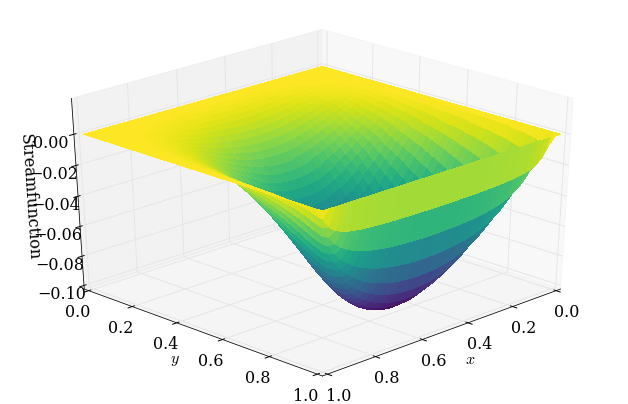

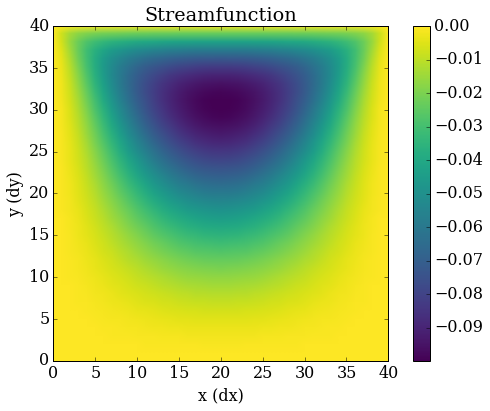

In [22]:
plot_3D(x,y,psi_gauss,'Streamfunction')
colormap(x,y,psi_gauss,'Streamfunction')

Il s'agit bien de la bonne solution. Nous allons étudier les différences de convergence entre Jacobi et Gauss-Seidel, mais avant cela nous allons implémenter une 3ème méthode très similaire qui est juste une légère modification de la méthode de Gauss-Seidel: la méthode SOR (Successive Over-Relaxation)

## 3. Méthode SOR 

Cette méthode consiste à utiliser une combinaison linéaire de la solution de l'itération précédente et de celle calculée par Gauss-Seidel:
\begin{equation}
\omega^{k+1}_{i,j} =(1-\epsilon)\omega^{k}_{i,j} + \frac{\epsilon}{4} \left(\omega^{k+1}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k+1}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation}
(valable seulement pour $\Delta x= \Delta y$)
\begin{equation}
\psi_{i,j}^{k+1}=(1-\epsilon)\psi_{i,j}^k + \epsilon\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k+1})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k+1})\Delta x^2+\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{equation}
où $\epsilon$ est un paramètre qui peut varier entre 0 et 2 pour que la solution reste stable. Si $\epsilon\leq 1$, SOR convergera plus lentement que Gauss-Seidel, et s'il est plus grand que 1, il convergera plus vite.
Il existe une valeur charnière de $\epsilon$ qui minimise le nombre d'itérations pour SOR. Nous ne possédons pas de formule pour déterminer cette valeur, nous allons donc la déterminer "à la main".

In [117]:
@jit(nopython=True)
def stokesSOR(w,psi,epsilon):
   
    l1norm_w = 1
    l1norm_psi=1
    wn = numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0
    normpsi_list=numpy.zeros(4060)
    
    while (l1norm_psi>l1_target or l1norm_w>l1_target):
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = (1-epsilon)*wn[j,i] + epsilon*.25 * (wn[j,i+1] + w[j,i-1] + wn[j+1,i] + w[j-1,i])
        
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                psi[j,i] = (1-epsilon)*psi[j,i]+ (epsilon/(2*(dx**2 + dy**2))) * \
                        ((psin[j,i+1]+psi[j,i-1])*dy**2 +\
                        (psin[j+1,i] + psi[j-1,i])*dx**2 +\
                         w[j,i]*dx**2*dy**2)
            
        ##B.C on the edge of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)
           
        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
        normpsi_list[iterations]= l1norm_psi
        
        iterations += 1 
        
    return psi,w,normpsi_list,iterations

Nous allons à présent déterminer la valeur de $\epsilon$ qui minimise le nombre d'itérations. On commence à $\epsilon=1$ (qui correspond au cas de Gauss-Seidel), et on va augmenter progressivement sa valeur jusqu'à ce que la solution ne soit plus stable, ensuite on extraira le minimum d'itérations et le $\epsilon$ correspondant.

In [118]:
def minimize_epsilon(emin,emax,nb_of_step):
    tiny=1e-8 #ceci permet d'éviter les problèmes dûs à l'erreur machine
    list_iterations=numpy.zeros((nb_of_step,2))
    epsilon=emin
    step=(emax-emin)/nb_of_step
    i=0
    while ((emax-epsilon)>tiny):
        x = numpy.linspace(0,1,nx)
        y = numpy.linspace(0,1,ny)
        w_epsilon = numpy.zeros((nx,ny))
        psi_epsilon=numpy.zeros((nx,ny))
        w_epsilon[-1,:]=-3/dy
        iterations_SOR= stokesSOR(w_epsilon.copy(),psi_epsilon.copy(),epsilon)[3]
        list_iterations[i,0]=epsilon
        list_iterations[i,1]=iterations_SOR
        i=i+1
        epsilon=epsilon+step
    return list_iterations

In [119]:
minimize_epsilon(1.0,1.5,5)

array([[  1.00000000e+00,   2.12000000e+03],
       [  1.10000000e+00,   1.75400000e+03],
       [  1.20000000e+00,   1.44800000e+03],
       [  1.30000000e+00,   1.18900000e+03],
       [  1.40000000e+00,   9.64000000e+02]])

A première vue, plus on augmente $\epsilon$, plus le nombre d'itérations diminue. Cependant, dès $\epsilon=1.5$, la méthode devient instable. Nous devons donc nous arrêter avant cette valeur. Nous allons maintenant chercher autour de $\epsilon=1.4$ la valeur minimale.

In [120]:
minimize_epsilon(1.35,1.45,5)

array([[    1.35,  1073.  ],
       [    1.37,  1028.  ],
       [    1.39,   985.  ],
       [    1.41,   943.  ],
       [    1.43,   901.  ]])

La valeur minimale du nombre d'itération se trouve autour de $\epsilon=1.43$. Affinons encore une fois notre recherche dans cette zone:

In [121]:
minimize_epsilon(1.42,1.44,20)

array([[   1.42 ,  922.   ],
       [   1.421,  920.   ],
       [   1.422,  918.   ],
       [   1.423,  916.   ],
       [   1.424,  914.   ],
       [   1.425,  912.   ],
       [   1.426,  910.   ],
       [   1.427,  908.   ],
       [   1.428,  906.   ],
       [   1.429,  904.   ],
       [   1.43 ,  901.   ],
       [   1.431,  899.   ],
       [   1.432,  897.   ],
       [   1.433,  895.   ],
       [   1.434,  893.   ],
       [   1.435,  891.   ],
       [   1.436,  889.   ],
       [   1.437,  888.   ],
       [   1.438,  894.   ],
       [   1.439,  933.   ]])

Notre meilleure estimation du minimum est $\epsilon=1.437$. Pour cette valeur, le nombre d'itérations est de 888, ce qui est nettement inférieur au nombre d'itérations pour Gauss-Seidel et Jacobi.

In [124]:
%%timeit
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w_SOR=numpy.zeros((nx,ny))
psi_SOR=numpy.zeros((nx,ny))
w_SOR[-1,:]=-3/dy
psi_SOR,w_SOR,normpsilist_SOR,iterations_SOR= stokesSOR(w_SOR.copy(),psi_SOR.copy(),1.42)

10 loops, best of 3: 23.2 ms per loop


In [128]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w_SOR=numpy.zeros((nx,ny))
psi_SOR=numpy.zeros((nx,ny))
w_SOR[:,-1]=-3/dy
psi_SOR,w_SOR,normpsilist_SOR,iterations_SOR= stokesSOR(w_SOR.copy(),psi_SOR.copy(),1.439)
print(iterations_SOR)

959


In [113]:
#Verification de la solution:
print(numpy.round(numpy.max(numpy.abs(psi_SOR[1:-1,1:-1])),4))
print(numpy.round(numpy.max(numpy.abs(w_SOR[1:-1,1:-1])),4))
print(numpy.round(psi_SOR[32,::8], 4))

0.0998
22.5608
[ 0.     -0.0575 -0.0944 -0.0944 -0.0575  0.    ]


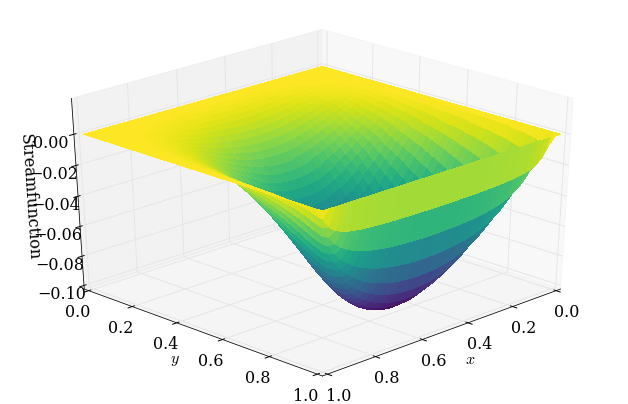

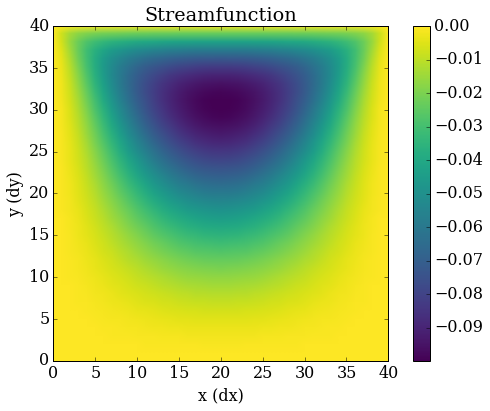

In [114]:
plot_3D(x,y,psi_SOR,'Streamfunction')
colormap(x,y,psi_SOR,'Streamfunction')

## Etude de la convergence des différentes méthodes:

A présent, on veut utiliser les listes des différence de normes L1 successives de $\psi$ pour chaque méthode afin de comparer la convergence des trois méthodes utilisées:

**Comparaison de la convergence:**

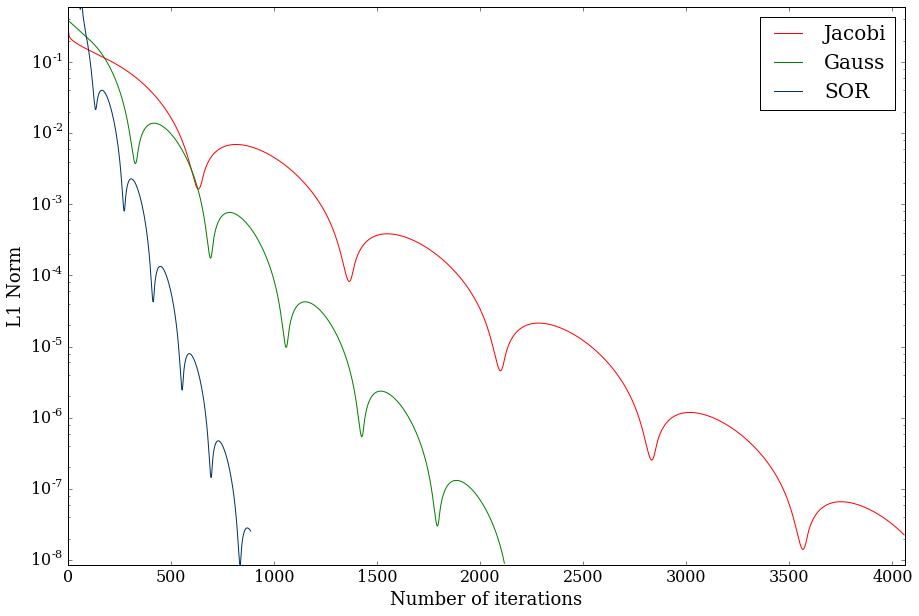

In [60]:
pyplot.figure(figsize=(15,10))
pyplot.semilogy(normpsilist_jac[:iterations_jac-1], color='red',label='Jacobi')
pyplot.semilogy(normpsilist_gauss[:iterations_gauss-1], color='green',label='Gauss')
pyplot.semilogy(normpsilist_SOR[:iterations_SOR-1], color='#003366',label='SOR')
pyplot.xlabel('Number of iterations', fontsize=18)
pyplot.ylabel('L1 Norm', fontsize=18)
pyplot.ylim(0,0.6) 
pyplot.xlim(0,4060)
pyplot.legend(loc='upper right',fontsize=20)
pyplot.close;

On observe comme on s'y attend que la convergence de la méthode SOR est plus rapide que celle de Gauss-Seidel, qui est elle-même plus rapide que celle de Jacobi. D'autre part, on observe que les différences de norme L1 de ces trois méthodes possèdent des "bosses": itérations ou au lieu de diminuer, la différence de norme L1 entre deux itérations successives augmente.
Une hypothèse d'explication est que comme dans ces méthodes, la condition au bord supérieur non nul se propage ligne par ligne à chaque itérations. Cependant lorsqu'elle atteint le bord, il se pourrait que cela crée une sorte "d'onde de choc" qui éloignerait temporairement la fonction de la solution (la différence de norme L1 entre deux itérations grandit) puis se résorberait. Ce phénomène semble se reproduire plusieurs fois dans chaque méthode ce qui correspondrait aux rebonds successifs.

## 4. Steepest Descent
Nous allons à présent résoudre notre système d'équations en utilisant les méthodes de Steepest Descent et du Conjugate Gradient. Ces méthodes sont fondamentalement différentes des trois précédentes car au lieu de faire progresser les conditions au bord ligne par ligne, on veut résoudre le problème de manière globale en l'écrivant sous forme de matrice.
De cette façon, le nombre d'itérations doit se réduire considérablement. Mais nous allons voir que tout ne se passe pas aussi simplement que prévu.

On considère l'équation comme une équation de matrice $Ax=b$.
Dans notre cas, on aura deux systèmes d'équations couplés:
$$A\omega=0$$
$$A\psi=-\omega$$
où $$A=\nabla^{2}$$
En discrétisant cet opérateur, on obtient que 

$$\nabla^{2}p=\frac{p_{i+1,j}^{k}-2p_{i,j}^{k}+p_{i-1,j}^{k}}{\Delta x^2}+\frac{p_{i,j+1}^{k}-2 p_{i,j}^{k}+p_{i,j-1}^{k}}{\Delta y^2}$$
Pour n'importe quelle fonction p.

## Code:

In [61]:
def steep_des(w,psi):
    

    l1norm_w = 1
    l1norm_psi=1

    Aresi_w=numpy.zeros((ny,nx))
    Aresi_psi= numpy.zeros((ny,nx))
    residual_w=numpy.zeros((ny,nx))
    residual_psi=numpy.zeros((ny,nx))
    iterations=0
    normpsi_list=numpy.zeros(5400)

    while (l1norm_psi>l1_target or l1norm_w>l1_target) :
        l1norm_w = 0
        l1norm_psi= 0
        
        wn = w.copy()
        psin=psi.copy()
        
            
        residual_w[1:-1,1:-1]= 4*wn[1:-1,1:-1] - wn[1:-1,2:] - wn[1:-1,:-2] - wn[2:, 1:-1] - wn[:-2, 1:-1]
        
        Aresi_w[1:-1,1:-1] = -4*residual_w[1:-1,1:-1] + \
                         residual_w[1:-1,2:] + residual_w[1:-1,:-2] + residual_w[2:, 1:-1] + residual_w[:-2, 1:-1]
        
        numw = numpy.sum(residual_w*residual_w)
        denw = numpy.sum(residual_w*Aresi_w)
        alphaw = numw/denw
        
        w= wn + alphaw*residual_w
        
        ##B.C on the edge of the square
        w[-1,:]=(-1/(dx)**2)*(4*psi[-2,:]-psi[-3,:]/2)-3.0/dy
        w[0,:]=(-1/(dx)**2)*(4*psi[1,:]-psi[2,:]/2) 
        w[:,-1]=(-1/(dy)**2)*(4*psi[:,-2]-psi[:,-3]/2)
        w[:,0]=(-1/(dy)**2)*(4*psi[:,1]-psi[:,2]/2)
         
        
        residual_psi[1:-1,1:-1] = -w[1:-1,1:-1]*(dx**2)+4*psin[1:-1,1:-1]\
                                -(psin[1:-1,2:]+psin[1:-1,:-2] +\
                                psin[2:,1:-1] + psin[:-2,1:-1])
        
                                                  
        Aresi_psi[1:-1,1:-1] = -4*residual_psi[1:-1,1:-1] + residual_psi[1:-1,2:] + residual_psi[1:-1,:-2] +\
                                residual_psi[2:,1:-1] + residual_psi[:-2,1:-1]
        

        numpsi = numpy.sum(residual_psi*residual_psi)
        denpsi = numpy.sum(residual_psi*Aresi_psi)
        alphapsi = numpsi/denpsi
            
       
        psi = psin + alphapsi*residual_psi
        

        l1norm_w=L1norm(w,wn)
        l1norm_psi=L1norm(psi,psin)
        
        normpsi_list[iterations]= l1norm_psi
        
        iterations += 1 
        
        
        
    print('Number of iterations: {0:d}'.format(iterations))
    print('L1 Norm for omega:',l1norm_w)
    print('L1 Norm for psi: ',l1norm_psi)

    return psi,w,normpsi_list,iterations

In [62]:
x= numpy.linspace(0,1,nx)
y= numpy.linspace(0,1,ny)

In [63]:
w_steep=numpy.zeros((ny,nx))
psi_steep=numpy.zeros((ny,nx))
w_steep[-1,:]=-3/dy
psi_steep,w_steep,normpsilist_steep,iterations_steep= steep_des(w_steep.copy(),psi_steep.copy())

Number of iterations: 4032
L1 Norm for omega: 9.997536733e-07
L1 Norm for psi:  1.86198122927e-08


In [64]:
#Vérification de la solution:
print(numpy.round(numpy.max(numpy.abs(psi_steep[1:-1,1:-1])),4))
print(numpy.round(numpy.max(numpy.abs(w_steep[1:-1,1:-1])),4))
print(numpy.round(psi_steep[32,::8], 4))

0.0998
22.5608
[ 0.     -0.0575 -0.0944 -0.0944 -0.0575  0.    ]


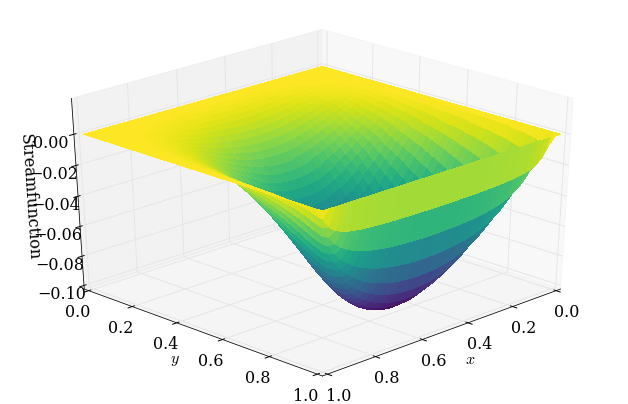

In [65]:
plot_3D(x,y,psi_steep,'Streamfunction')

Notre code converge vers la bonne solution... mais il met pour cela 4032 étapes, soit presque autant que Jacobi! 

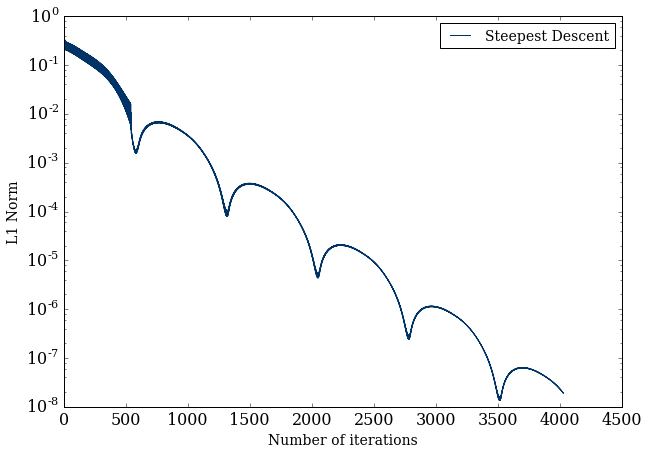

In [66]:
pyplot.figure(figsize=(10,7))
pyplot.semilogy(normpsilist_steep[:iterations_steep-1], color='#003366',label='Steepest Descent')
pyplot.xlabel('Number of iterations', fontsize=14)
pyplot.ylabel('L1 Norm of psi', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.close;

Avant 500 itérations, le trait est très gras, nous faisons un zoom sur cette zone pour comprendre ce qu'il se passe:

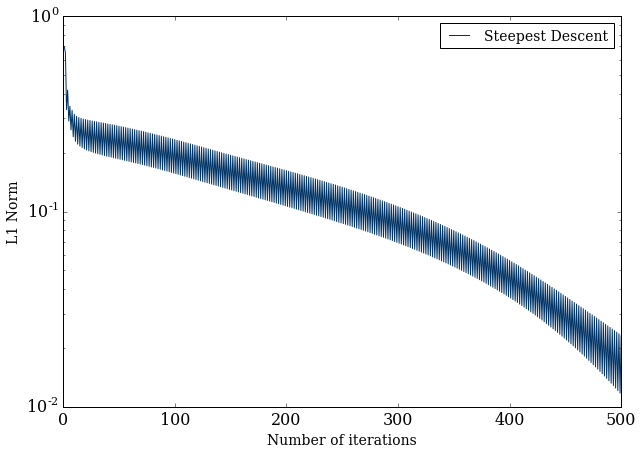

In [67]:
pyplot.figure(figsize=(10,7))
pyplot.semilogy(normpsilist_steep[:iterations_steep-1], color='#003366',label='Steepest Descent')
pyplot.xlabel('Number of iterations', fontsize=14)
pyplot.ylabel('L1 Norm of psi', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.xlim(0,500)
pyplot.ylim(0.01,1.0)
pyplot.close;

On voit que la différence de norme L1 n'est pas linéaire. Elle change fort de valeurs à chaque itérations, ce qui donne l'impression d'une courbe grasse. Cela est dû au fait que la méthode traite le problème de manière générale, mais comme les conditions au bord ne se propagent que lentement, c'est comme s'il fallait à chaque itération résoudre un problème différent, et donc un système d'équation différent ( le b change à chaque fois). C'est pour cela que cette méthode converge si lentement, alors qu'elle devrait en théorie converger en quelques itérations seulement. 

## 5. Conjugate gradient

Pour la méthode du conjugate gradient, cette façon de faire ne converge pas. Nous allons devoir aborder le problème d'un autre angle.

Pour illustrer ce problème, nous allons utiliser le code du conjugate gradient du notebook d'apprentissage mais en l'appliquant à un problème légèrement différent: au lieu d'avoir un b non nul et des conditions au bord nulles, on considère le même problème mais avec un b nul et des conditions au bord non nulles:

In [68]:
#Ce code provient du notebook 05_03_Iterate.This du Module 5 du numerical-mooc:

def conjugate_gradient_2d(p):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l2_norm = 1
    iterations = 0
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    
    r[1:-1,1:-1] = 4*p[1:-1,1:-1] - \
        p[1:-1,2:] - p[1:-1,:-2] - p[2:, 1:-1] - p[:-2, 1:-1]
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad[1:-1,1:-1] = -4*d[1:-1,1:-1]+d[1:-1,2:]+d[1:-1,:-2]+\
        d[2:, 1:-1] + d[:-2, 1:-1]
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l2_norm > l1_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad[1:-1,1:-1] = -4*d[1:-1,1:-1] + d[1:-1,2:] + d[1:-1,:-2] + \
            d[2:, 1:-1] + d[:-2, 1:-1]
        sigma = numpy.sum(d*Ad)
        
        # BCs are automatically enforced
        
        l2_norm = L1norm(pk,p)
        iterations += 1
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p    


Number of CG iterations: 126


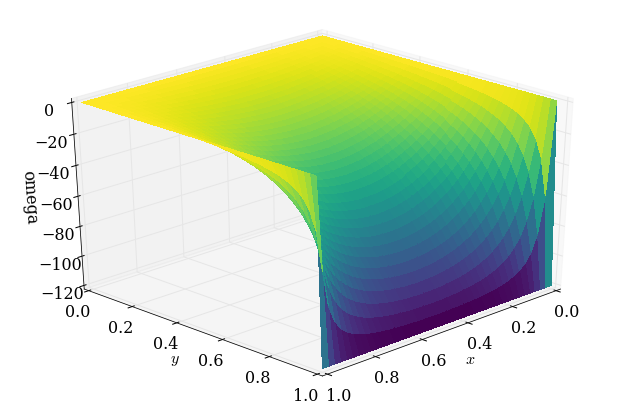

In [69]:
x= numpy.linspace(0,1,nx)
y= numpy.linspace(0,1,ny)
omega=numpy.zeros((ny,nx))
omega[-1,:]=-3/dy
omega=conjugate_gradient_2d(omega.copy())
plot_3D(x,y,omega,'omega')

Pour le même problème, il faut ici 126 itérations pour converger vers la solution, contre 2 itérations dans le cas traité dans l'exemple (Module5, 05_03_Iterate.This). Ceci illustre parfaitement le problème qu'on rencontre lorsque l'on met des conditions au bord et qu'on essaye de résoudre par Steepest Descent ou Conjugate Gradient

### Equation biharmonique
Au lieu de résoudre le système d'équation découplées, nous le retravaillons pour obtenir l'équation biharmonique:


\begin{equation}
\nabla^4\psi=0\\
\Leftrightarrow \frac{\partial^4 \psi}{\partial y^4} + 2\frac{\partial^4 \psi}{\partial y^2 \partial x^2}+\frac{\partial^4 \psi}{\partial x^4}=0\\
\Leftrightarrow \left(\frac{\psi_{i-2,j} - 4\psi_{i-1,j} +6\psi_{i,j} - 4\psi_{i+1,j} + \psi_{i+2,j}}{\Delta x^4}\right) +2\left(\frac{\Big[\psi_{i-1,j-1} - 2\psi_{i-1,j} + \psi_{i-1,j+1}\Big] - 2\Big[\psi_{i,j-1} - 2\psi_{i,j} + \psi_{i,j+1}\Big]+\Big[\psi_{i+1,j-1} - 2\psi_{i+1,j} + \psi_{i+1,j+1}\Big]}{\Delta x^2 \Delta y^2}\right)
+\left(\frac{\psi_{i,j-2} - 4\psi_{i,j-1} +6\psi_{i,j} - 4\psi_{i,j+1} + \psi_{i,j+2}}{\Delta y^4}\right)=0
\end{equation}

**Conditions au bord:**

TOP:
\begin{equation}
\psi=0 \Leftrightarrow \psi_{i,ny-1}=0\\
\frac{\partial \psi}{\partial y}=1 \Leftrightarrow \psi_{i,ny-2}=\frac{\psi_{i,ny-3}}{4} - \frac{\Delta y}{2}
\end{equation}
BOTTOM:
\begin{equation}
\psi=0\Leftrightarrow \psi_{i,0}=0\\
\frac{\partial \psi}{\partial y}=0 \Leftrightarrow \psi_{i,1}=\frac{\psi_{i,2}}{4}
\end{equation}
LEFT:
\begin{equation}
\psi=0\Leftrightarrow \psi_{0,j}=0\\
\frac{\partial \psi}{\partial x}=0 \Leftrightarrow \psi_{1,j}=\frac{\psi_{2,j}}{4}
\end{equation}
RIGHT:
\begin{equation}
\psi=0\Leftrightarrow \psi_{nx-1,j}=0\\
\frac{\partial \psi}{\partial x}=0 \Leftrightarrow \psi_{nx-2,j}=\frac{\psi_{nx-3,j}}{4}
\end{equation}

#### Problème à 1D:
Afin de pouvoir bien comprendre la méthode du conjugate gradient et l'utilisation de la matrice, nous commencons par résoudre le même problème à 1 dimension:

In [70]:
def matrixA_1D(psi):
    n=psi.shape
    Apsi = numpy.zeros(n)
    b = numpy.zeros(n)
    b[-4]=1/(2*dx**3)
    b[-3]=-2/(dx**3)
  
    Apsi[4:-4]=(psi[2:-6]-4*psi[3:-5]+6*psi[4:-4]-4*psi[5:-3]+psi[6:-2])/(dx**4)
    Apsi[2]=(5*psi[2]-4*psi[3]+psi[4])/(dx**4)
    Apsi[3]=(-15/4*psi[2]+6*psi[3]-4*psi[4]+psi[5])/(dx**4)
    Apsi[-4]=(psi[-6]-4*psi[-5]+6*psi[-4]-15/4*psi[-3])/(dx**4)
    Apsi[-3]=(psi[-5]-4*psi[-4]+5*psi[-3])/(dx**4)
    
    return Apsi,b

In [71]:
def biharmonic1D(p):
    n= p.shape
    r  = numpy.zeros(n) # residual
    Ad  = numpy.zeros(n) # to store result of matrix multiplication 
    b = matrixA_1D(p)[1]
    l1_norm = 1
    iterations = 0
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    Ad  = matrixA_1D(p)[0]
    r[2:-2] = b[2:-2]- Ad[2:-2]
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad = matrixA_1D(d)[0]
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm >l1_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad = matrixA_1D(d)[0]
        sigma = numpy.sum(d*Ad)
        
        # BC
        p[1]=p[2]/4
        p[-2]=p[-3]/4-dx/2
        
        l1_norm = L1norm(pk,p)
        iterations += 1
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p    

In [72]:
x=numpy.linspace(0,1,nx)
psi=numpy.zeros(nx)
psi_CG1D=biharmonic1D(psi)

Number of CG iterations: 448


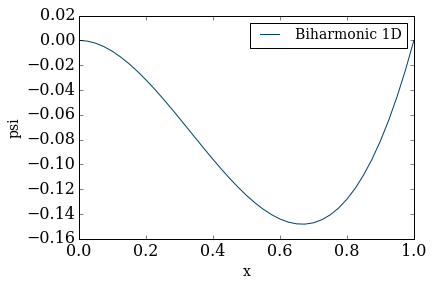

In [73]:
pyplot.plot(x,psi_CG1D, color='#004366',label='Biharmonic 1D')
pyplot.xlabel('x', fontsize=14)
pyplot.ylabel('psi', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.close;

Le nombre d'itérations est relativement bas (448) et la forme ressemble bien à une coupe selon x du résultat attendu à 2D.
Nous pouvons donc à présent passer à la résolution du problème à deux dimensions:

In [74]:
def matrixA_2D(psi):
    ny, nx = psi.shape
    Apsi = numpy.zeros((ny,nx))
   

    psi[-2,:]=psi[-3,:]/4-dy/2
    psi[:,1]=psi[:,2]/4
    psi[:,-2]=psi[:,-3]/4
    psi[1,:]=psi[2,:]/4
    
    Apsi[2:-2,2:-2] = ((psi[2:-2,:-4]+psi[2:-2,4:]+psi[:-4,2:-2]+psi[4:,2:-2])\
                    +2*(psi[1:-3,1:-3]+psi[3:-1,1:-3]+psi[1:-3,3:-1]+psi[3:-1,3:-1])\
                    -8*(psi[2:-2,1:-3]+psi[2:-2,3:-1]+psi[1:-3,2:-2]+psi[3:-1,2:-2])\
                    +20*psi[2:-2,2:-2])/(dx**4)
    
    return Apsi

In [75]:
def Biharmonic2D(psi):

    ny, nx = psi.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l1_norm = 1
    iterations = 0
    normpsi_list=numpy.zeros(100000)
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual

    Ad = matrixA_2D(psi)
    #psi[-2,:]=psi[-3,:]/4
    r =  - Ad
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad = matrixA_2D(d)
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm > l1_target:

        psik = psi.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        psi = psik + alpha*dk
        
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        
        psi[-2,:]=psi[-3,:]/4
        psi[:,1]=psi[:,2]/4
        psi[:,-2]=psi[:,-3]/4
        psi[1,:]=psi[2,:]/4
        
        Ad = matrixA_2D(d)
        sigma = numpy.sum(d*Ad)
    
        
        l1_norm = L1norm(psik,psi)
        normpsi_list[iterations]= l1_norm
        iterations += 1
        
    print('Number of iterations: {0:d}'.format(iterations))
    print('L1 Norm for psi: ',l1_norm)
    return psi,normpsi_list,iterations 

Number of iterations: 974
L1 Norm for psi:  9.09531660799e-07


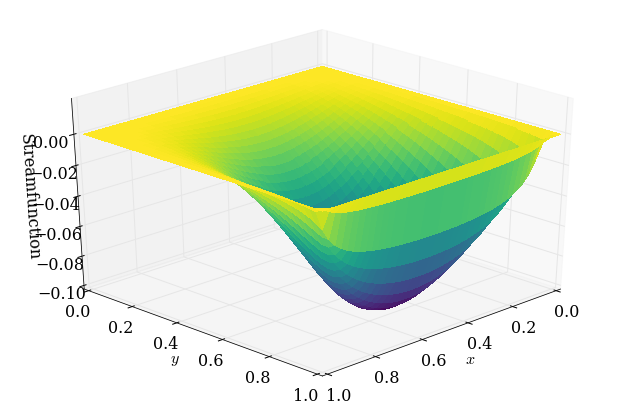

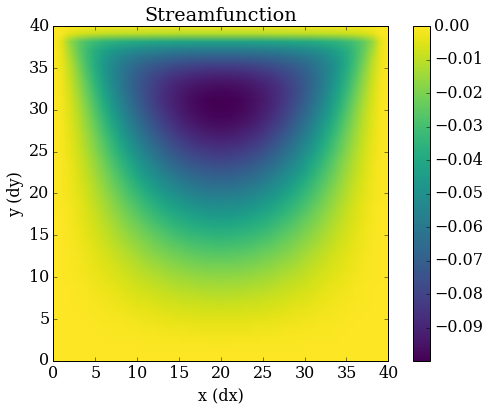

In [76]:
x_CG2D = numpy.linspace(0,1,41)
y_CG2D = numpy.linspace(0,1,41)
psi_CG2D=numpy.zeros((41,41))
psi_CG2D,normpsilist_CG2D,iterations_CG2D=Biharmonic2D(psi_CG2D.copy())
plot_3D(x_CG2D,y_CG2D,psi_CG2D,'Streamfunction')
colormap(x_CG2D,y_CG2D,psi_CG2D,'Streamfunction')

In [77]:
#Vérification de la solution:
print(numpy.round(numpy.max(numpy.abs(psi_CG2D[1:-1,1:-1])),4))
print(numpy.round(psi_CG2D[32,::8], 4))

0.0999
[ 0.     -0.0574 -0.0945 -0.0945 -0.0574  0.    ]


Ces résultats ne sont pas exactement égaux à ceux déterminés par les autres méthodes mais on voit qu'ils en sont très proches. Comme les méthodes utilisées sont très différentes, cela n'est pas étonnant. Pour avoir une meilleure précision pour ces valeurs, il nous faudrait utiliser de plus grandes grilles en x et en y, mais cela rendrait le calcul plus lourd. Malgré tout, on voit que la différence entre nos valeurs pour la résolution des équations couplées et pour la résolution de l'équation biharmonique est comprise entre 0.1% et 0.2%, ce qui nous semble satisfaisant.

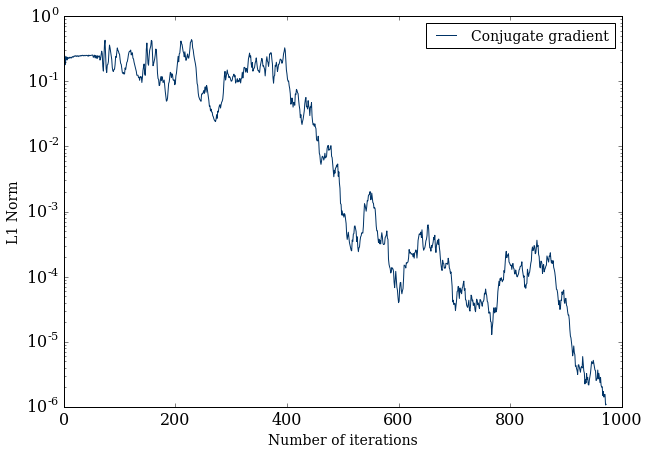

In [79]:
pyplot.figure(figsize=(10,7))
pyplot.semilogy(normpsilist_CG2D[:iterations_CG2D-1], color='#003366',label='Conjugate gradient')
pyplot.xlabel('Number of iterations', fontsize=14)
pyplot.ylabel('L1 Norm', fontsize=14)
pyplot.legend(loc='upper right',fontsize=14)
pyplot.close;

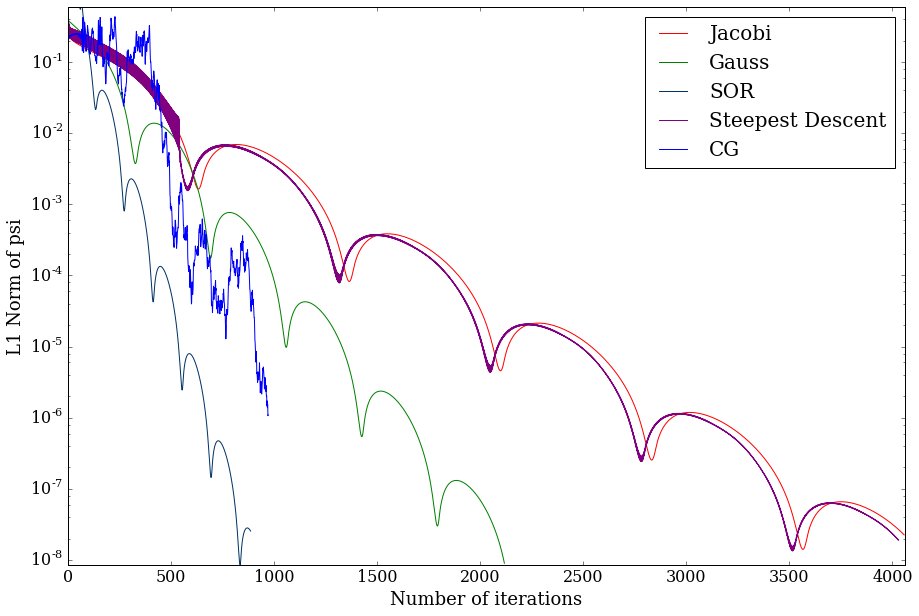

In [83]:
pyplot.figure(figsize=(15,10))
pyplot.semilogy(normpsilist_jac[:iterations_jac-1], color='red',label='Jacobi')
pyplot.semilogy(normpsilist_gauss[:iterations_gauss-1], color='green',label='Gauss')
pyplot.semilogy(normpsilist_SOR[:iterations_SOR-1], color='#003366',label='SOR')
pyplot.semilogy(normpsilist_steep[:iterations_steep-1], color='purple',label='Steepest Descent')
pyplot.semilogy(normpsilist_CG2D[:iterations_CG2D-1], color='blue',label='CG')
pyplot.xlabel('Number of iterations', fontsize=18)
pyplot.ylabel('L1 Norm of psi', fontsize=18)
pyplot.ylim(0,0.6) 
pyplot.xlim(0,4060)
pyplot.legend(loc='upper right',fontsize=20)
pyplot.close;

## 6. Conclusion

Nous avons pu résoudre le problème de l'écoulement de Stokes en utilisant les différentes méthodes de relaxation. Les résultats obtenus concordent dans chacuns des cas. Pour le cas du Conjugate Gradient, nous avons dû utiliser l'équation biharmonique pour résoudre le problème. De plus, contrairement à ce à quoi l'on pourrait s'attendre, la méthode la plus efficace dans notre cas (qui converge le plus rapidement) est la méthode de SOR (Successive-Over-relaxation). Le fait que les méthodes de Steepest Descent et de Conjugate Gradient ne convergent pas en quelques itérations comme on s'y attendait et dû aux conditions au bord sur la dérivée première du flot $\psi$. Celle-ci modifie en quelque sorter la valeur du terme $b$ si on écrit notre équation sous la forme $Ax=b$. Par conséquent, à chaque itération, le problème change et cela ralentit la convergence. Quand on dessine le graphique de la convergence,il apparaît de grandes fluctuations qui nous confortent dans cette hypothèses.
Malgré tout, la méthode de Conjugate Gradient reste la deuxième méthode la plus efficace après celle de SOR.